In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from nltk.corpus import stopwords
from matplotlib import pyplot

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from scipy.special import logsumexp

In [2]:
df = pd.read_csv("yelp_review_sentiment_2classes.tsv", delimiter="\t")
df = df.dropna()

In [3]:
def softmax(z):
    # Ensure numerical stability
    exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_scores / exp_scores.sum(1)[:, np.newaxis]

def crossentropy(x, y):
    m = (x * y).sum(1)
    ce = np.log(m)
    return -ce.sum()

class SoftmaxRegression(object):
    def __init__(self, w=None, b=None, lr=0.1, epochs=10):
        self.lr = lr
        self.epochs = epochs
        self.w = w
        self.b = b
        self.label_bin = OneHotEncoder()

    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {"w": self.w, "b": self.b, "lr": self.lr, "epochs": self.epochs}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        y = np.asarray(self.label_bin.fit_transform(y.reshape(y.shape[0], 1)).todense())
        limit = 1./np.sqrt(X.shape[1])
        self.w = np.random.uniform(low=-limit, high=limit, size=(X.shape[1], y.shape[1]))
        self.b = np.random.uniform(low=-limit, high=limit, size=(y.shape[1]))

        for i in range(self.epochs):
            z = X.dot(self.w) + self.b
            z = softmax(z)
            loss = crossentropy(z, y)

            # Calculate gradients
            dW = (X.T.dot(z - y) / X.shape[0])
            db = z.sum(0) / X.shape[0]

            self.w = self.w - self.lr * dW
            self.b = self.b - self.lr * db

    def predict_proba(self, X):
        z = X.dot(self.w) + self.b
        z = softmax(z)
        return z
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)

In [4]:
class NaiveBayesClassification(object):
    def __init__(self):
        self.label_bin = OneHotEncoder()

    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        _y = np.asarray(self.label_bin.fit_transform(y.reshape(y.shape[0], 1)).todense())
        num_class = np.unique(y).shape[0]

        self.prior = np.zeros((num_class))
        for i in range(num_class):
            self.prior[i] = (y == 1).sum() / y.shape[0]
        self.log_prior = np.log(self.prior)

        sum_words = (_y.T @ X) + 1
        total_words = sum_words.sum()
        self.log_likelihood = np.log(sum_words) - np.log(total_words)

    def predict_proba(self, X):
        llh = X @ self.log_likelihood.T
        posterior = llh + self.log_prior
        # Normalized by Z but in logarithmic form
        posterior = posterior - logsumexp(posterior, axis=1).reshape(-1, 1)
        return np.exp(posterior)

    def predict(self, X):
        preds = self.predict_proba(X)
        return preds.argmax(axis=1)

# Machine Learning Model Experiments with 2 Classes

In [5]:
en_stopwords = stopwords.words('english') + ["-PRON-", "-pron-", "PRON", "pron"]

cnt_vec = CountVectorizer(ngram_range=(1, 3), min_df=10, stop_words=en_stopwords)
tfidf_vec = TfidfVectorizer(ngram_range=(1, 3), min_df=10, stop_words=en_stopwords)
label_enc = LabelEncoder()
normalizer = Normalizer()
pca_cnt = TruncatedSVD(300)
pca_tfidf = TruncatedSVD(300)

In [6]:
train, test = train_test_split(df, test_size=0.1, shuffle=True, random_state=42)

cnt_vec.fit(train["text"])
tfidf_vec.fit(train["text"])
label_enc.fit(train["sentiment"])

pca_cnt.fit(cnt_vec.transform(train["text"]))
pca_tfidf.fit(tfidf_vec.transform(train["text"]))

TruncatedSVD(n_components=300)

In [14]:
# logistic = SoftmaxRegression(lr=0.5, epochs=500)
nb = NaiveBayesClassification()


combinations = [
    # (logistic, cnt_vec, None, None),
    # (logistic, tfidf_vec, None, None),
    # (logistic, cnt_vec, normalizer, None),
    # (logistic, tfidf_vec, normalizer, None),
    # (logistic, cnt_vec, None, pca_cnt),
    # (logistic, tfidf_vec, None, pca_tfidf),
    (nb, cnt_vec, None, None)
]

# res2 = {}
for comb in combinations:
    model = comb[0]
    model_name = type(model).__name__
    
    print("Prepare data to train..")
    featurizer = comb[1]
    featurizer_name = type(featurizer).__name__
    X_train = featurizer.transform(train["text"])
    y_train = label_enc.transform(train["sentiment"])
    # X_test = featurizer.transform(test["text"])
    # y_test = label_enc.transform(test["sentiment"])
    
    normalizer_name = "None"
    if comb[2]:
        normalizer = comb[2]
        normalizer_name = type(normalizer).__name__
        X_train = normalizer.fit_transform(X_train)
        # X_test = normalizer.transform(X_test)
        
    decomposer_name = "None"
    if comb[3]:
        decomposer = comb[3]
        decomposer = comb[3]
        decomposer_name = type(decomposer).__name__
        X_train = decomposer.transform(X_train)
        # X_test = decomposer.transform(X_test)
        
    metadata = model_name + "-" + featurizer_name + "-" + normalizer_name + "-" + decomposer_name
    
    print("Cross-validate {}".format(metadata))
    score = cross_validate(model, X_train, y_train,
                           scoring=["f1_micro", "precision_micro", "recall_micro"],
                           cv=5, n_jobs=-1, return_train_score=True)
    res2[metadata] = score
    print(metadata, score)
    print()

Prepare data to train..
Cross-validate NaiveBayesClassification-CountVectorizer-None-None
NaiveBayesClassification-CountVectorizer-None-None {'fit_time': array([1.89704418, 1.88639092, 1.87597895, 1.87908721, 1.77037001]), 'score_time': array([0.20330787, 0.20943499, 0.20133185, 0.21191192, 0.23423386]), 'test_f1_micro': array([0.83300738, 0.83574095, 0.83654103, 0.83280736, 0.83425193]), 'train_f1_micro': array([0.8476809 , 0.84871433, 0.85032558, 0.85009779, 0.84922549]), 'test_precision_micro': array([0.83300738, 0.83574095, 0.83654103, 0.83280736, 0.83425193]), 'train_precision_micro': array([0.8476809 , 0.84871433, 0.85032558, 0.85009779, 0.84922549]), 'test_recall_micro': array([0.83300738, 0.83574095, 0.83654103, 0.83280736, 0.83425193]), 'train_recall_micro': array([0.8476809 , 0.84871433, 0.85032558, 0.85009779, 0.84922549])}



In [15]:
analysis_df = pd.DataFrame()
for k, v in res2.items():
    tmp_df = pd.DataFrame.from_dict(res2[k])
    tmp_df["meta"] = k
    
    analysis_df = pd.concat([analysis_df, tmp_df])

In [16]:
analysis_df.head(10)

,fit_time,score_time,test_f1_micro,train_f1_micro,test_precision_micro,train_precision_micro,test_recall_micro,train_recall_micro,meta
0,597.291035,0.576677,0.915837,0.921215,0.915837,0.921215,0.915837,0.921215,SoftmaxRegression-CountVectorizer-None-None
1,596.765024,0.671023,0.916859,0.921149,0.916859,0.921149,0.916859,0.921149,SoftmaxRegression-CountVectorizer-None-None
2,595.724154,0.964928,0.917304,0.920626,0.917304,0.920626,0.917304,0.920626,SoftmaxRegression-CountVectorizer-None-None
3,596.944726,0.578998,0.914704,0.921321,0.914704,0.921321,0.914704,0.921321,SoftmaxRegression-CountVectorizer-None-None
4,595.553050,0.784166,0.916504,0.921404,0.916504,0.921404,0.916504,0.921404,SoftmaxRegression-CountVectorizer-None-None
0,414.206411,0.214243,0.857032,0.860665,0.857032,0.860665,0.857032,0.860665,SoftmaxRegression-TfidfVectorizer-None-None
1,414.046816,0.238054,0.860276,0.860160,0.860276,0.860160,0.860276,0.860160,SoftmaxRegression-TfidfVectorizer-None-None
2,412.775682,0.231219,0.859632,0.861021,0.859632,0.861021,0.859632,0.861021,SoftmaxRegression-TfidfVectorizer-None-None
3,412.750242,0.235447,0.857965,0.860854,0.857965,0.860854,0.857965,0.860854,SoftmaxRegression-TfidfVectorizer-None-None
4,414.183979,0.174807,0.861232,0.860215,0.861232,0.860215,0.861232,0.860215,SoftmaxRegression-TfidfVectorizer-None-None


In [2]:
analysis_df = pd.read_csv("scratch_performance.csv")

(0.8, 0.95)

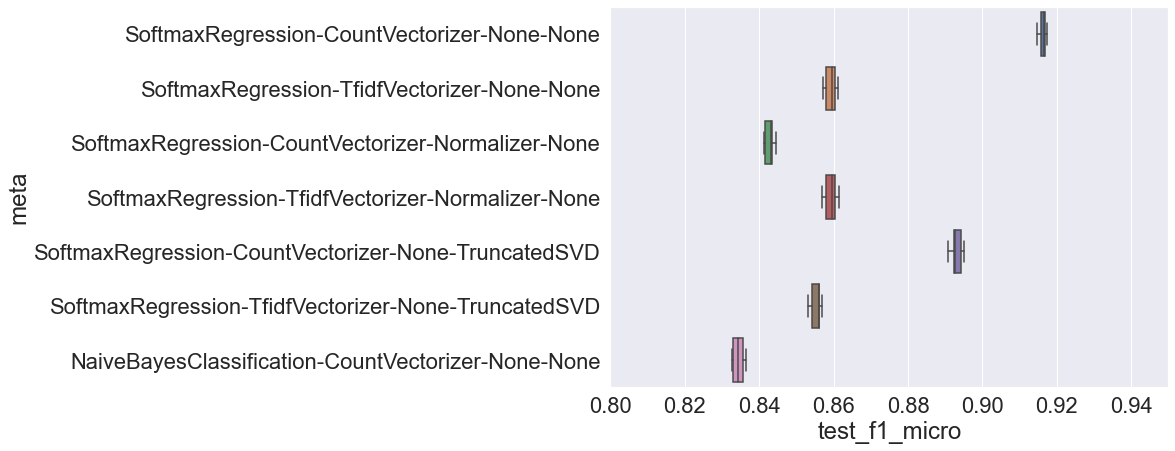

In [3]:
sns.set(font_scale=2)
a4_dims = (10, 7)
fig, ax = pyplot.subplots(figsize=a4_dims)
g = sns.boxplot(data=analysis_df, x="test_f1_micro", y="meta")
g.set_xlim([0.8, 0.95])

In [18]:
analysis_df.to_csv("scratch_performance.csv", index=False)